## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [227]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set()
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [156]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [157]:
len(df)

294478

c. The number of unique users in the dataset.

In [158]:
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [159]:
sum(df['converted'] == 1)/len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [160]:
print(sum(~((df['landing_page'] == 'new_page') & (df['group'] == 'treatment')) & ~((df['landing_page'] == 'old_page') & (df['group'] == 'control'))))



3893


f. Do any of the rows have missing values?

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


From the df.info() output above, we see that none of the rows have missing values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [162]:
df2 = df[((df['landing_page'] == 'new_page') & (df['group'] == 'treatment')) | ((df['landing_page'] == 'old_page') & (df['group'] == 'control'))]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [163]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [164]:
len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [165]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [166]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [168]:
df2 = df2.drop_duplicates(subset='user_id')
#check whether duplicate is still there
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [169]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [170]:
sum(df2['converted'] == 1)/len(df2)

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [205]:
actual_p_old = sum((df2['converted'] == 1) & (df2['group'] == 'control'))/sum(df2['group'] == 'control')
actual_p_old



0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [206]:
actual_p_new = sum((df2['converted'] == 1) & (df2['group'] == 'treatment'))/sum(df2['group'] == 'treatment')
actual_p_new


0.11880806551510564

d. What is the probability that an individual received the new page?

In [173]:
sum(df2['landing_page'] == 'new_page')/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

I don't think that there is sufficient evidence to say that the new treatment page leads to more conversions since the probability of an individual converting regardless of the page they received was already 0.12, and the probability that an individual converted given that they were in the control group was 0.12, while the probability that an individual converted given that they were in the treatment group was 0.1188. Thus, if anything, it seems that the treatment group individuals have less probability of converting than the control group individuals.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null hypothesis:**

The conversion rate of users who see the old page is greater than or equal to the conversion rate of users who see the new page.

$H_0: p_{old} >= p_{new}$

**Alternative hypothesis:**

The conversion rate of users who see the old page is lesser than the conversion rate of users who see the new page.

$H_1:  p_{old} < p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. 

a. What is the **convert rate** for $p_{new}$ under the null? 

In [174]:
#p_new = convert rate for new landing_page
p_new = sum(df2['converted'] == 1)/len(df2)
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [177]:
#p_old = convert rate for old landing_page
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [179]:
#n_new = number of users who saw the new landing page
n_new = sum((df2['landing_page'] == 'new_page'))
n_new

145310

d. What is $n_{old}$?

In [178]:
#n_old = number of users who saw the old landing page
n_old = sum((df2['landing_page'] == 'old_page'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [190]:
new_page_converted = np.random.binomial(1,p_new,n_new)
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [191]:
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [194]:
p_diff = sum(new_page_converted)/n_new - sum(old_page_converted)/n_old
p_diff

0.0029849505278290445

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [275]:
#perform simulations via array update method for efficiency
p_diffs = np.random.binomial(n_old, p_old, 10000)/n_old - np.random.binomial(n_new, p_new, 10000)/n_new
print(f'Mean p_diff: {np.mean(p_diffs)}')


Mean p_diff: -6.924044318611711e-07


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Upper bound: 0.0023869535458429943, lower bound: -0.002388338354706717


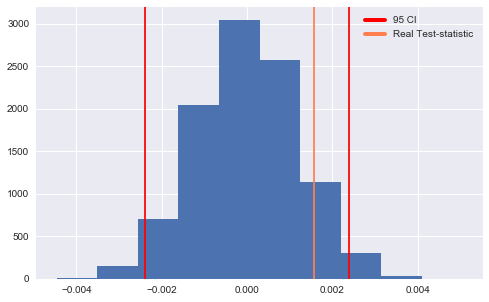

In [291]:
plt.figure(figsize=(8,5))
plt.hist(p_diffs)

#plot actual test-statistic
plt.axvline(x=(actual_p_old-actual_p_new), color = 'coral')

#plot 95% confidence interval
std = p_diffs.std()
m = p_diffs.mean()
upper_bound, lower_bound = m + 2*std, m - 2*std
print(f"Upper bound: {upper_bound}, lower bound: {lower_bound}")
plt.axvline(x=upper_bound, color = 'red')
plt.axvline(x=lower_bound, color = 'red')

#add legend
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='coral', lw=4)]

plt.legend(custom_lines, ['95 CI', 'Real Test-statistic'])

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [295]:
p_greater = sum(p_diffs > (actual_p_old-actual_p_new))/len(p_diffs)
p_smaller = sum(p_diffs < (actual_p_old-actual_p_new))/len(p_diffs)

print(f"Actual observed difference: {round(actual_p_old-actual_p_new,4)}")
print(f"Proportion of p_diffs greater than the actual observed difference: {p_greater}")
print(f"Proportion of p_diffs smaller than the actual observed difference: {p_smaller}")

Actual observed difference: 0.0016
Proportion of p_diffs greater than the actual observed difference: 0.0909
Proportion of p_diffs smaller than the actual observed difference: 0.9091


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The p-value for conducting the left-tailed test $H_0$ : p_old - p_new >= 0 vs $H_1$ : p_old - p_new < 0 is the probability that we would observe a test statistic less than t* = 0.0016 if the population p_old - p_new really were 0. From running simulations, we found a p-value of 0.9091, i.e. 0.9091 of the simulated runs p_diff are smaller than the p_diff of the actual data. 

The p-value, 0.9091, tells us it is "highly likely" that we would observe the test statistic t* in the direction of $H_1$ if the null hypothesis were true. Therefore, our initial assumption that the null hypothesis is true must be correct. That is, since the p-value, 0.9091, is much higher than α = 0.05, we fail to reject the null hypothesis $H_0$ : p_old >= p_new in favor of the alternative hypothesis $H_1$ : p_old < p_new.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [280]:
import statsmodels.api as sm

convert_old = sum((df2['converted'] == 1) & (df2['landing_page'] == 'old_page'))
convert_new = sum((df2['converted'] == 1) & (df2['landing_page'] == 'new_page'))
n_old = sum(df2['landing_page'] == 'old_page')
n_new = sum(df2['landing_page'] == 'new_page')


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [296]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)


1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score indicates that the real difference in conversion rates - p_diff - is 1.3 standard deviations away from the mean, towards the positive side; the p-value of 0.905 indicates that 0.905 proportion of the simulated p_diffs are smaller than the actual p_diff. 

This agrees with the findings in parts j and k where we can see that the real p_diff is greater than the mean but less than upper bound of the 95 CI (which indicates that it could very plausibly be ~1.3 standard deviations greater than the mean); the p-value obtained from the simulations was 0.9091, which is very similar to 0.905 as obtained from the built-in function.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since the dependent outcome is binary - conversion or no conversion - logistic regression can be used.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [253]:
#assign 1 if treatment group and 0 if control group
df2['intercept'] = 1
df2['ab_page'] = (df2['group'] == 'treatment').astype(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [254]:
import statsmodels.discrete.discrete_model as sm

y = df2['converted']
X = df2[['ab_page','intercept']]
model = sm.Logit(y, X)
results = model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [255]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:48:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.19.

In regression, the p-values are always given for testing if the parameter of an intercept or slope are equal to 0 in the null hypothesis. So, the null and alternative hypotheses are:

**Null hypothesis:**

$H_0: p_{old} = p_{new}$

**Alternative hypothesis:**

$H_1:  p_{old} \neq p_{new}$ 

The alternative hypothesis can also be interpreted in the following manner:

$H_1:  p_{old} < p_{new} $ or $ p_{old} > p_{new}$

In part 2, the null and alternative hypotheses were set to be: 

**Null hypothesis:**

$H_0: p_{old} >= p_{new}$

**Alternative hypothesis:**

$H_1:  p_{old} < p_{new}$

Since the regression hypotheses-testing is two-tailed, and the original hypotheses-testing procedure was one-tailed, the regression analysis p-value takes into account the probablity that the test-statistic could be falling into the tail of either end of the t-distribution. 

Referring to the regression $H_1$ above, we see that the regression alternative hypothesis is testing whether $p_{old} < p_{new} $ or $ p_{old} > p_{new}$, and so the p-value of **0.19** obtained symbolizes the probability that we would see $p_{old} < p_{new} $ or $ p_{old} > p_{new}$ given that the null hypothesis, $p_{old} = p_{new}$ is true. In comparison, the hypotheses-testing procedure had a much higher p-value of **0.91** since it is only testing for the probability that the null hypothesis is true given that the alternative hypothesis goes in the direction of $p_{old} < p_{new}$.

Another way to look at this is that if the null hypothesis in the original procedure was $p_{old} <= p_{new}$ alternative hypothesis in the original procedure was $p_{old} > p_{new}$ we would get a much lower p-value of ~0.09, which indicates that while still **not statistically significant**, it is much more likely that the null hypothesis could potentially fail to be accepted.

Hence, the difference in p-values obtained is due to the fixed one-tail direction of the alternative hypothesis in the hypotheses-testing procedure, vs the two-tailed, bidirectional alternative hypothesis in the regression procedure.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There are pros and cons to considering other factors to add into the regression model. The pro is that you are putting more data into your model, which arguably can only make your model more informed and representative of the behavior that you are trying to predict for. 

The con is that the additional data could also be irrelevant noise that ends up making your model less accurate. When adding extra variables, you would also need to check that they are not intercorrelated with each other or the existing variables, otherwise your model may end up difficult to control in terms of identifying relevant variables, and the results may end up difficult to interpret.

However, I would say that with proper regression methods, your model should be able to let you know when an added variable is just noise by assigning it a low coefficient, and so unless we are very confident that the added variable is completely irrelevant, we should strive to include them in the model. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [259]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [269]:
country_dummies = pd.get_dummies(df_new['country'], drop_first=True)
df_new = df_new.join(country_dummies, on='user_id')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [271]:
y = df_new['converted']
X = df_new[['UK','US','intercept']]
model = sm.Logit(y, X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               1.521e-05
Time:                        22:28:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
==============================================================================
"""

**Explanation:**

From the results, it appears that the p-value of UK is 0.074, while the p-value of US is 0.129. Considering that a two-tailed hypothesis test was performed during regression, we can infer that since UK and US both have p-values > 0.05, they do not have a statistically significant effect on the conversion rate. 

That being said, if we divided the p-values by 2 to obtain the corresponding p-value for the more sensitive one-tailed hypothesis test, we see that UK's p-value is $0.074/2 = 0.037$ and US's p-value is $0.129/2 = 0.0645$. And so, UK's p-value would be statistically significant with an alpha of 0.05 on a one-tailed hypothesis test. This only applies if we decide to keep alpha at 0.05 despite using a one-tailed test, which would make the statistical significance threshold more sensitive. If we adjusted it to be $\alpha = 0.025$, then both p-values would be statistically insignificant even after dividing by 2.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [274]:
df_new['US_interaction'] = df_new['US']*df_new['ab_page']
df_new['UK_interaction'] = df_new['UK']*df_new['ab_page']

### Fit Your Linear Model And Obtain the Results
y = df_new['converted']
X = df_new[['UK','US','ab_page','US_interaction','UK_interaction','intercept']]
model = sm.Logit(y, X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               3.482e-05
Time:                        22:51:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
UK                 0.0118      0.040      0.296      0.767      -0.066       0.090
US                 0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page           -0.0674      0.052     -1.297      0.195      -0.169       0.034
US_interaction     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_interaction     0.0783      0.057      1.378      0.168      -0.033       0.190
intercept         -2.0040      0.036    -55.008      0.000      -2.075      -1.933
==================================================================================
"""

**Explanation:**
    
From the results, it appears that after adding the interaction terms of US x ab_page and UK x ab_page, the p-value drastically increases for the US and UK terms. This suggests that US and UK as standalone variables do not have significant effects on the conversion outcome.

The lowest p-value is obtained from the UK x ab_page interaction term, but since $0.168/2 = 0.084$ is still greater than a one-tailed alpha term of 0.05, we can infer that the effect of the interaction term on the conversion outcome is also not statistically significant.